In [249]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [250]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [251]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Get the first 5000 rows
df = df.head(15000)
df

NoticeId,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,BaseType,ArchiveType,ArchiveDate,SetASideCode,SetASide,ResponseDeadLine,NaicsCode,ClassificationCode,PopStreetAddress,PopCity,PopState,PopZip,PopCountry,Active,AwardNumber,AwardDate,Award$,Awardee,PrimaryContactTitle,PrimaryContactFullname,PrimaryContactEmail,PrimaryContactPhone,PrimaryContactFax,SecondaryContactTitle,SecondaryContactFullname,SecondaryContactEmail,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""97ec6ab3d5d4454192a8828827de6f…","""Whooster Web-Based Software""","""HQ003422P0171""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 23:09:21.289-04""","""Award Notice""","""Special Notice""","""auto15""","""2022-10-14""","""""","""""","""""","""511210""","""7A21""","""""","""""","""""","""""","""""","""No""","""HQ003422P0171""","""2022-09-29""","""125000.00""","""WHOOSTER INC TX 78610-2850 USA""","""""","""Roya Sterner""","""roya.m.sterner.civ@mail.mil""","""5712254264""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""203011000""","""USA""","""""","""https://sam.gov/opp/97ec6ab3d5…","""The Whooster Web Based Softwar…"
"""c15a7148317b44eeac210a7b640687…","""Beckman Coulter Reagents and S…","""W81K0222Q0162""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W40M RHCO PACIFIC""","""W81K02""","""2022-09-30 23:01:45.502-04""","""Presolicitation""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-10-11T10:00:00-10:00""","""325413""","""6550""","""""","""""","""""","""""","""USA""","""No""","""""","""""","""""","""""","""""","""Megumi Kuwada""","""megumi.kuwada.civ@mail.mil""","""8084385125""","""""","""""","""""","""""","""""","""""","""OFFICE""","""HI""","""FORT SHAFTER""","""96858-5098""","""USA""","""""","""https://sam.gov/opp/c15a714831…","""The Medical Readiness Contract…"
"""bf103afa7b4b455bb1541eb450e381…","""8(a) WebEOC IL5 Cloud Services…","""HQ003422C0130""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 22:12:14.082-04""","""Award Notice""","""Award Notice""","""auto15""","""2022-10-14""","""8AN""","""8(a) Sole Source (FAR 19.8)""","""""","""541519""","""DF01""","""""","""""","""""","""""","""""","""No""","""HQ003422C0130""","""2022-09-29""","""4838341.62""","""SPAARK INC PA 17201 USA""","""""","""Roya Sterner""","""roya.m.sterner.civ@mail.mil""","""5712254264""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""203011000""","""USA""","""""","""https://sam.gov/opp/bf103afa7b…","""Direct Award of an 8(a) contra…"
"""d1619b0084ac4d439585b727343b46…","""Leslie Valve IDIQ - Sources So…","""N4523A22RC04N81""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""PUGET SOUND NAVAL SHIPYARD IMF""","""N4523A""","""2022-09-30 22:05:45.599-04""","""Sources Sought""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-10-14T11:00:00-07:00""","""811310""","""J048""","""""","""""","""""","""""","""USA""","""No""","""""","""""","""""","""""","""""","""Bart Franklin""","""bart.franklin@navy.mil""","""3609793786""","""""","""""","""Chris Parker""","""Christopher.L.Parke1@navy.mil""","""3609793943""","""""","""OFFICE""","""WA""","""BREMERTON""","""98314-5001""","""USA""","""""","""https://sam.gov/opp/d1619b0084…","""Puget Sound Naval Shipyard and…"
"""48b6b27846bd4155990cdc2f2be335…","""PFPA BALLISTIC VEST AND PLATES""","""HQ003422Q0206""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 21:36:36.

In [252]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""97ec6ab3d5d4454192a8828827de6f…","""Whooster Web-Based Software""","""HQ003422P0171""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 23:09:21.289-04""","""Award Notice""","""Special Notice""","""auto15""","""2022-10-14""","""""","""""","""""","""511210""","""7A21""","""""","""""","""""","""""","""""","""No""","""HQ003422P0171""","""2022-09-29""","""125000.00""","""WHOOSTER INC TX 78610-2850 USA""","""""","""Roya Sterner""","""roya.m.sterner.civ@mail.mil""","""5712254264""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""203011000""","""USA""","""""","""https://sam.gov/opp/97ec6ab3d5…","""The Whooster Web Based Softwar…"
"""c15a7148317b44eeac210a7b640687…","""Beckman Coulter Reagents and S…","""W81K0222Q0162""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W40M RHCO PACIFIC""","""W81K02""","""2022-09-30 23:01:45.502-04""","""Presolicitation""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-10-11T10:00:00-10:00""","""325413""","""6550""","""""","""""","""""","""""","""USA""","""No""","""""","""""","""""","""""","""""","""Megumi Kuwada""","""megumi.kuwada.civ@mail.mil""","""8084385125""","""""","""""","""""","""""","""""","""""","""OFFICE""","""HI""","""FORT SHAFTER""","""96858-5098""","""USA""","""""","""https://sam.gov/opp/c15a714831…","""The Medical Readiness Contract…"
"""bf103afa7b4b455bb1541eb450e381…","""8(a) WebEOC IL5 Cloud Services…","""HQ003422C0130""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 22:12:14.082-04""","""Award Notice""","""Award Notice""","""auto15""","""2022-10-14""","""8AN""","""8(a) Sole Source (FAR 19.8)""","""""","""541519""","""DF01""","""""","""""","""""","""""","""""","""No""","""HQ003422C0130""","""2022-09-29""","""4838341.62""","""SPAARK INC PA 17201 USA""","""""","""Roya Sterner""","""roya.m.sterner.civ@mail.mil""","""5712254264""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""203011000""","""USA""","""""","""https://sam.gov/opp/bf103afa7b…","""Direct Award of an 8(a) contra…"
"""d1619b0084ac4d439585b727343b46…","""Leslie Valve IDIQ - Sources So…","""N4523A22RC04N81""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""PUGET SOUND NAVAL SHIPYARD IMF""","""N4523A""","""2022-09-30 22:05:45.599-04""","""Sources Sought""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-10-14T11:00:00-07:00""","""811310""","""J048""","""""","""""","""""","""""","""USA""","""No""","""""","""""","""""","""""","""""","""Bart Franklin""","""bart.franklin@navy.mil""","""3609793786""","""""","""""","""Chris Parker""","""Christopher.L.Parke1@navy.mil""","""3609793943""","""""","""OFFICE""","""WA""","""BREMERTON""","""98314-5001""","""USA""","""""","""https://sam.gov/opp/d1619b0084…","""Puget Sound Naval Shipyard and…"
"""48b6b27846bd4155990cdc2f2be335…","""PFPA BALLISTIC VEST AND PLATES""","""HQ003422Q0206""","""DEPT OF DEFENSE""",97,"""WASHINGTON HEADQUARTERS SERVIC…","""97F5""","""WASHINGTON HEADQUARTERS SERVIC…","""HQ0034""","""2022-09-30 21:36:36.

In [253]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 15000         ┆ 0              │
│ title                 ┆ 10451         ┆ 0              │
│ sol_                  ┆ 11918         ┆ 0              │
│ department_ind_agency ┆ 50            ┆ 0              │
│ cgac                  ┆ 49            ┆ 1              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 838           ┆ 0              │
│ countrycode           ┆ 21            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 15000         ┆ 0              │
│ description           ┆ 9704          ┆ 0              │
└───────────────────────┴───────────────┴

In [254]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office', 'aac_code', 
                    'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 
                    'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 
                    'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 
                    'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 
                    'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 
                    'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 
                    'countrycode', 'additionalinfolink', 'link', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [255]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format

df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""97ec6ab3d5d4454192a8828827de6f…",10128,4867,10,97,125,130,1127,763,14898,0,8,0,129,0,0,0,436,400,0,0,0,0,0,0,2337,109,"""125000.00""",3143,0,4334,4745,1916,0,0,0,0,0,0,4,11,489,138,18,0,8907,7482
"""c15a7148317b44eeac210a7b640687…",3743,10793,10,21,35,54,966,1052,14897,3,7,0,0,0,0,1565,130,328,0,0,0,0,73,0,0,0,"""""",0,0,3539,4143,2979,0,0,0,0,0,0,4,15,183,780,18,0,11279,7010
"""bf103afa7b4b455bb1541eb450e381…",2908,4862,10,97,125,130,1127,763,14896,0,0,0,129,2,2,0,508,579,0,0,0,0,0,0,2323,109,"""4838341.62""",2638,0,4334,4745,1916,0,0,0,0,0,0,4,11,489,138,18,0,11157,2118
"""d1619b0084ac4d439585b727343b46…",6530,6180,10,17,36,44,739,837,14895,6,7,0,0,0,0,1659,636,708,0,0,0,0,73,0,0,0,"""""",0,0,490,1831,1289,0,0,334,77,482,0,4,53,59,809,18,0,12250,5148
"""48b6b27846bd4155990cdc2f2be335…",7608,4872,10,97,125,130,1127,763,14894,0,0,0,130,10,13,0,99,433,0,1184,18,266,73,0,2305,110,"""2500000.00""",2632,0,5436,5388,2435,0,0,1348,1980,0,0,4,11,489,138,18,0,4318,8083
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""870f91dd35a54221a1d6ebfdf6ae78…",2840,2841,10,21,35,54,1000,1075,4,1,1,2,189,10,13,524,347,392,57,98,15,1422,73,0,0,0,"""""",0,0,3809,4046,0,0,0,0,0,0,0,4,38,167,81,18,0,7949,698
"""c901b4b052534a9596e72d456ae29b…",2462,2075,49,36,124,61,15,314,3,3,4,2,104,0,0,446,271,322,245,0,0,394,0,0,0,0,"""""",3225,34,53,41,2627,0,0,0,0,0,0,4,50,213,272,18,0,11722,2591
"""127516f621114ec086d5dc0946ff3b…",278,10535,10,21,35,54,1099,1004,2,1,1,0,116,10,13,456,291,306,0,918,56,65,73,0,0,0,"""""",0,0,5296,5344,2054,0,0,1254,1415,757,0,4,34,392,20,18,0,1086,8415


In [256]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid', 'award_']

In [257]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [258]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
0,97ec6ab3d5d4454192a8828827de6f2f,10128,4867,10,97.0,125,130,1127,763,14898,...,0,0,4,11,489,138,18,0,8907,7482
2,bf103afa7b4b455bb1541eb450e38128,2908,4862,10,97.0,125,130,1127,763,14896,...,0,0,4,11,489,138,18,0,11157,2118
4,48b6b27846bd4155990cdc2f2be335c5,7608,4872,10,97.0,125,130,1127,763,14894,...,0,0,4,11,489,138,18,0,4318,8083
5,a952448f3f3c441f950c4d93606dd21d,5806,4343,10,57.0,34,67,310,662,14893,...,678,0,4,7,115,677,18,0,9948,0
6,92e917c86b08460d9b6e179cc3068769,6319,409,3,12.0,6,15,882,59,14892,...,0,0,4,18,377,509,18,0,8635,0


In [259]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [260]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [261]:
print(X_train)

                               noticeid  title   sol_  department_ind_agency  \
4877   d0edb99392cd429c85d5a98c8d4c32c9   5732    331                      3   
11713  b9b9e51d5597494ea89799e5f87a5dc5   1007   8545                     10   
725    3e2f552eb0c2417eb00308bf2dcfeaa3   5728  10635                     10   
9146   1a71db54b8894157bfe9129c05e8919e     91   8175                     10   
6558   a120f69e70e2467c82537a0986b5366a   2540   7423                     10   
...                                 ...    ...    ...                    ...   
7282   ddf39a8172ea46788668c0220bab37b1   1313   5509                     10   
11479  a852eba46a7c47e6817d82c8c2202b31   1250   9759                     10   
11560  b520d6569b9e4ea297160d0228bcaace   1807   1324                     21   
11932  d83294bfb8844a35974256fe25bcc7db   5017    964                     21   
1457   dc665f1bb6074b2bb1aa2d9ff0d484dd   9530  10092                     10   

       cgac  sub_tier  fpds_code  offic

In [262]:
print(X_test)

                               noticeid  title   sol_  department_ind_agency  \
2549   8e2c73a2afaa4d329b04fa50e6d03cae  10181   1762                     42   
13062  b1e344e15b0a46a1b18e5d55e2b1214b   6617  10347                     10   
7496   2cb8df06fba3470aa70be1ab81f549d7   1741   7751                     10   
12022  9cf3e253ab11450681f7a3fe28157d2b   9491   7133                     10   
10993  b3ba600745844cee97ae8f739a1b8a2d   3204   4815                     10   
...                                 ...    ...    ...                    ...   
573    3c02ce55be574badacf90181272889a9   4651  11040                     10   
4467   f1909d7d26824477933e8d2436e0de79   3600   6731                     21   
1532   b521341899cd43b0917ce332250243b8   5360    640                      5   
7495   a99240749f5c465e984b8c61099f5818   1204   6943                     10   
68     0ed17404d5e14db59877252941decec5   9613   1473                     24   

       cgac  sub_tier  fpds_code  offic

In [263]:
print(y_train)

4877        53526.79
11713       31566.00
725      20738644.56
9146        26920.52
6558        58157.00
            ...     
7282          991386
11479     4215873.68
11560         250000
11932        8623.65
1457        69987.66
Name: award_, Length: 4922, dtype: object


In [264]:
print(y_test)

2549       2776191.2
13062    27071585.75
7496       250000.00
12022      641009.92
10993      352976.50
            ...     
573      40000000.00
4467       867721.18
1532        27745.00
7495        33345.92
68        1995000.00
Name: award_, Length: 1231, dtype: object


In [265]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [266]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [267]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [268]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [269]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns if col.startswith('a') or col.startswith('p') or col.startswith('s')]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['sol_', 'sub_tier', 'aac_code', 'posteddate', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'state', 'additionalinfolink']
        sol_  sub_tier  aac_code  posteddate  archivetype  archivedate  \
4877     331        57        52       10059            0          121   
11713   8545        28       908        3265            0          115   
725    10635        35      1040       14183            2          139   
9146    8175        28       909        5818            0          119   
6558    7423        28       899        8389            0          121   
...      ...       ...       ...   

In [270]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [271]:
# Remove '$' and ',' then convert to float
y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [273]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 29
Number of columns in X_test: 29


In [274]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:61986972.38302
[1]	validation_0-rmse:49443880.06152
[2]	validation_0-rmse:41917503.86501
[3]	validation_0-rmse:38748588.64621
[4]	validation_0-rmse:36436799.65861
[5]	validation_0-rmse:35253046.23820
[6]	validation_0-rmse:34624018.02837
[7]	validation_0-rmse:35868027.35517
[8]	validation_0-rmse:35614095.05607
[9]	validation_0-rmse:35422562.20102
[10]	validation_0-rmse:35790068.15202
[11]	validation_0-rmse:35754323.37217
[12]	validation_0-rmse:36341272.08760
[13]	validation_0-rmse:36450743.38521
[14]	validation_0-rmse:36655016.75560
[15]	validation_0-rmse:36597164.59383
[16]	validation_0-rmse:36496263.10493
[17]	validation_0-rmse:36481157.99797
[18]	validation_0-rmse:36428870.54282
[19]	validation_0-rmse:36400235.75831
[20]	validation_0-rmse:36402372.73585
[21]	validation_0-rmse:36366063.50829
[22]	validation_0-rmse:36556793.01353
[23]	validation_0-rmse:36610273.53633
[24]	validation_0-rmse:36687086.66558
[25]	validation_0-rmse:36615672.68277
[26]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [275]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)


XGBoost MSE: 1334601271781909.2, R2: 0.11156072473763834


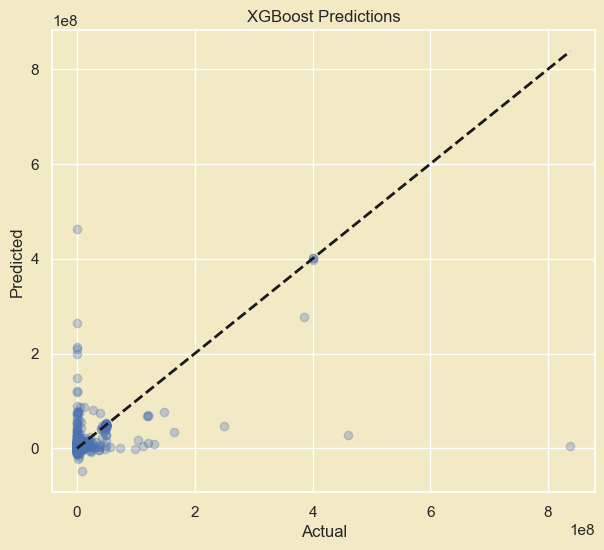

In [276]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(7, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [277]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [278]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date, set_aside_code, set_aside, response_deadline, naics_code, classification_code, pop_street_address, pop_city, pop_state, pop_zip, pop_country, active, award_number, award_date, award_amount, awardee, primary_contact_title, primary_contact_fullname, primary_contact_email, primary_contact_phone, primary_contact_fax, secondary_contact_title, secondary_contact_fullname, secondary_contact_email, secondary_contact_phone, secondary_contact_fax, organization_type, state, city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country, active,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [279]:
X_train.dtypes.to_frame('Data Type')

,Data Type
sol_,int64
sub_tier,int64
aac_code,int64
posteddate,int64
archivetype,int64
archivedate,int64
setasidecode,int64
setaside,int64
popstreetaddress,int64
popcity,int64


In [280]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

4922 row(s) have 0 missing values
Total number of rows with missing values: 0


In [281]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

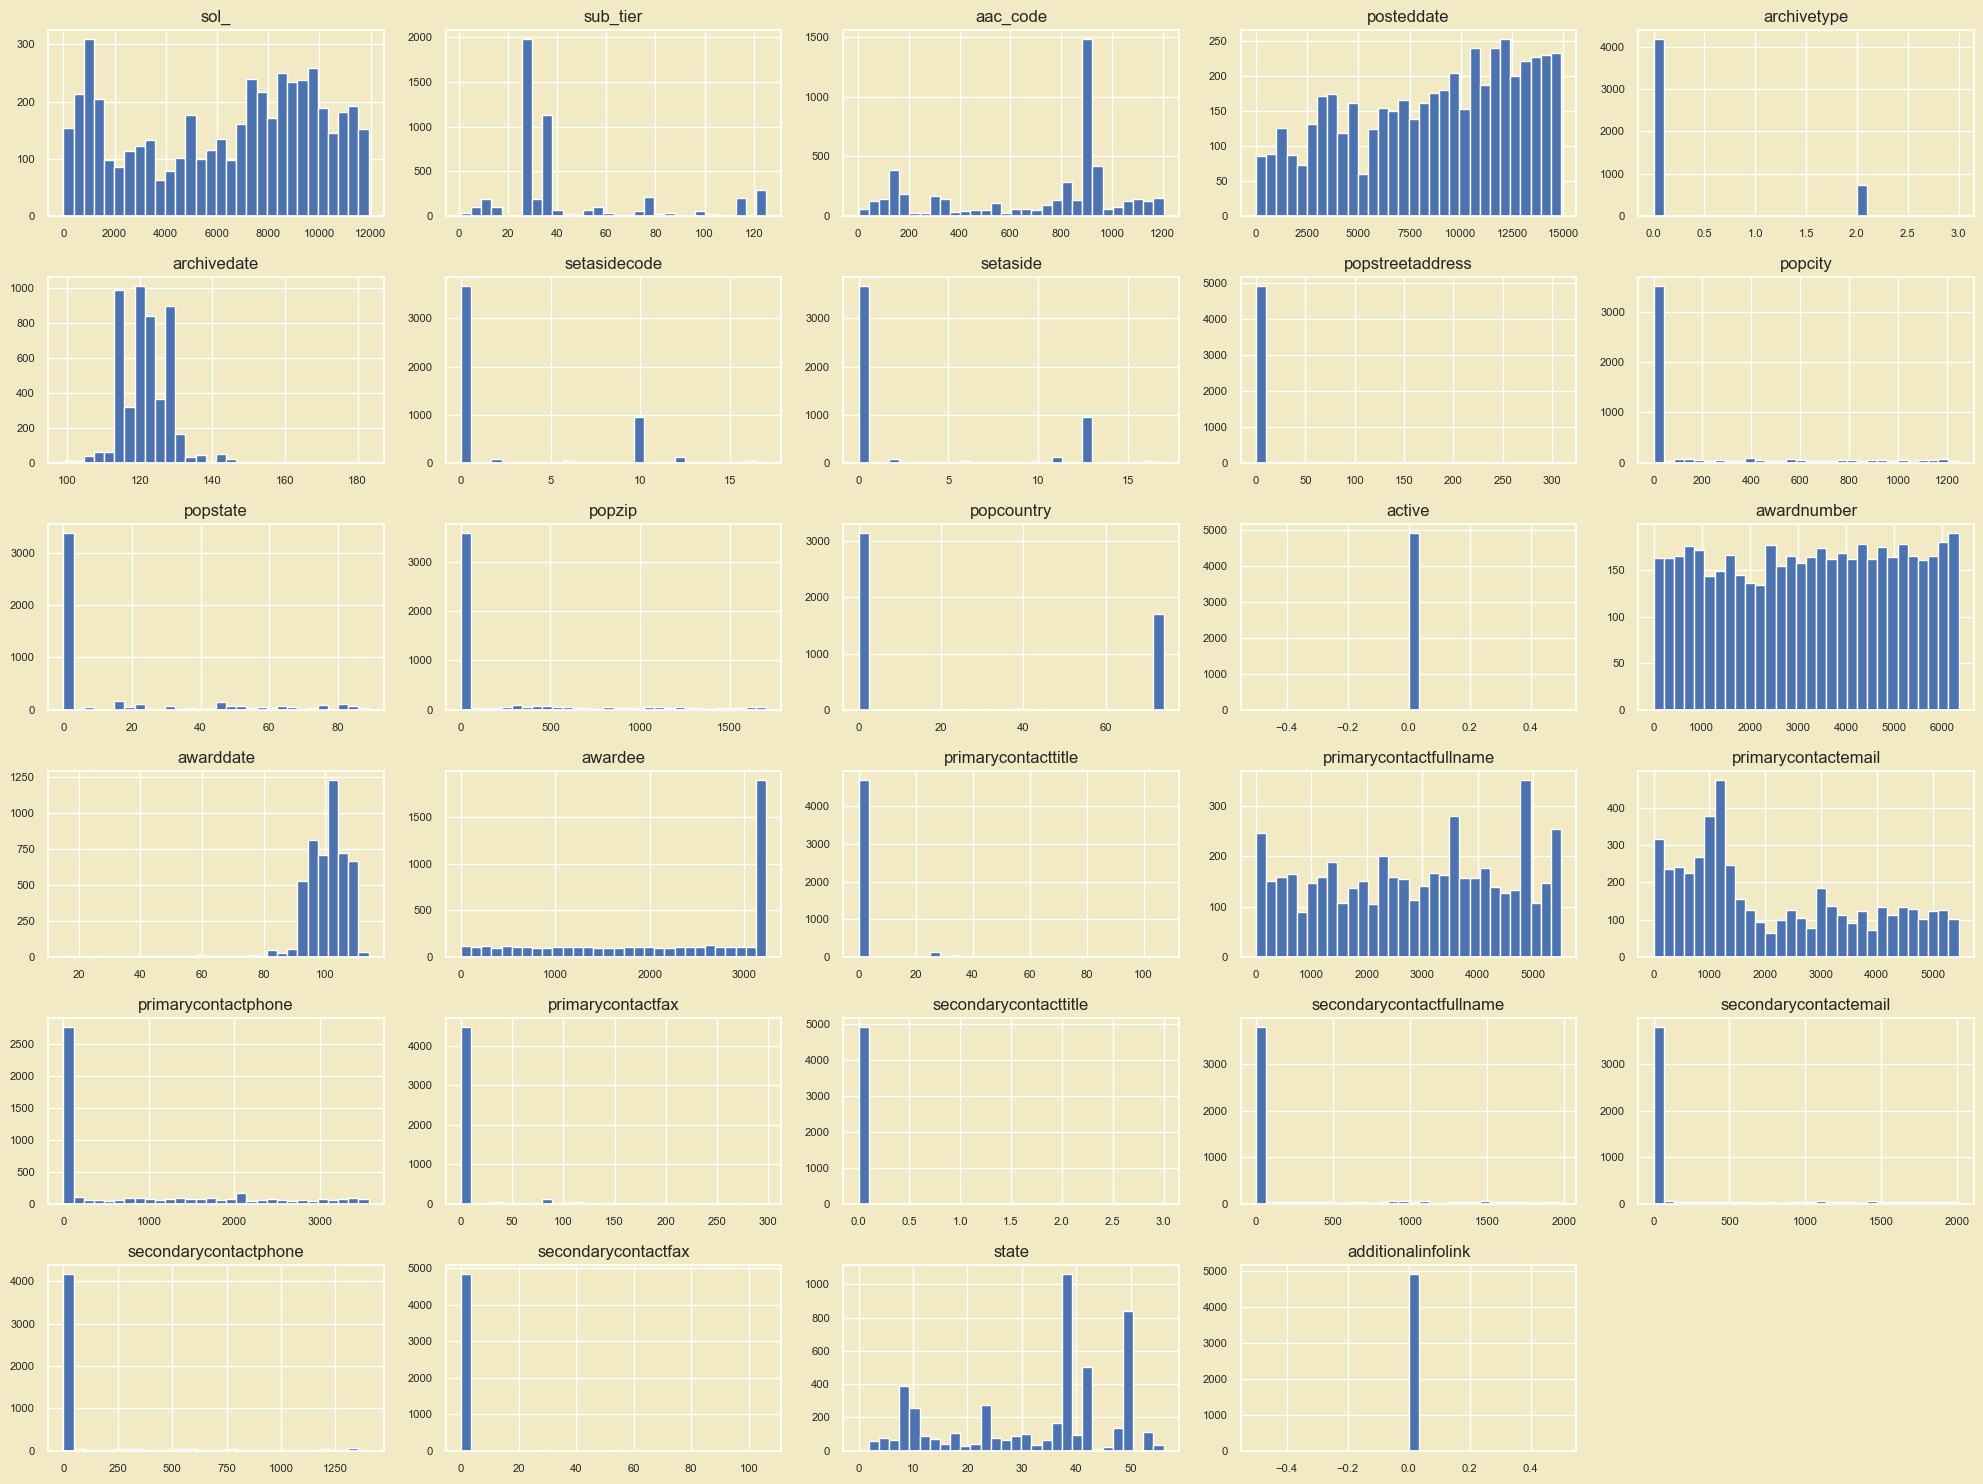

In [282]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [283]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4922 entries, 4877 to 1457
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   sol_                      4922 non-null   int64
 1   sub_tier                  4922 non-null   int64
 2   aac_code                  4922 non-null   int64
 3   posteddate                4922 non-null   int64
 4   archivetype               4922 non-null   int64
 5   archivedate               4922 non-null   int64
 6   setasidecode              4922 non-null   int64
 7   setaside                  4922 non-null   int64
 8   popstreetaddress          4922 non-null   int64
 9   popcity                   4922 non-null   int64
 10  popstate                  4922 non-null   int64
 11  popzip                    4922 non-null   int64
 12  popcountry                4922 non-null   int64
 13  active                    4922 non-null   int64
 14  awardnumber               4922 non-null   

In [284]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [285]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")


Random Forest MSE: 2.114140619797032e+18, R2: -1406.3758206054902
Ridge Regression MSE: 6.449411991560975e+17, R2: -428.33504086958175


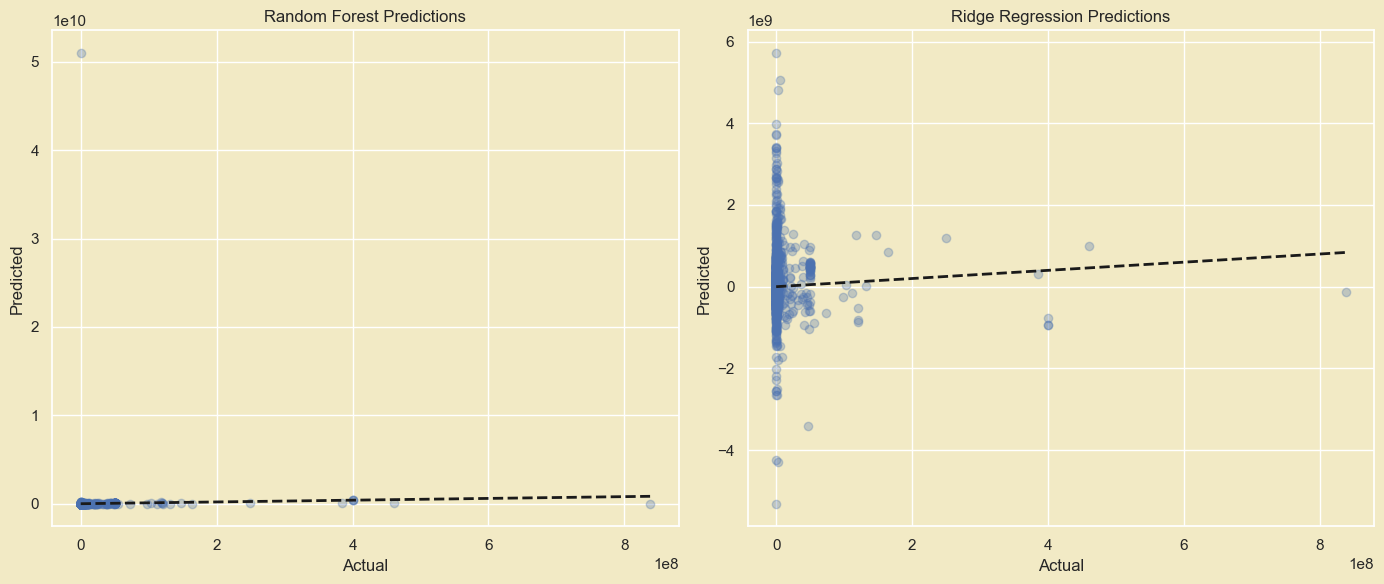

In [286]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()